# Домашнее задание 3
## Сравнение интересов аудитории телеканалов НТВ и Дождь с помощью тематического моделирования LDA

Задача:
Сравнить интересы аудитории телеканолов НТВ и Дождь с помощью методов тематического моделирования
1. Получить данные по аудитории из социальной сети ВК
2. Зарегистрировать приложение, получить app_id, access_token
3. Скачать данные по пользователям в каждой из групп (id групп ВК даны ниже, tvrain_id, ntv_id)
4. Взять небольшую выборку из каждой совокупности телезрителей(около 1000-2000 человек, т.к. 300k-400k слишком много), с которыми работать дальше
5. Обучить LDA модель на их подписках
6. По группам, на которые подписаны эти люди, полуичть ключевые слова групп, на которые они подписаны
7. Получить распределение интересов людей для каждой совокупности, сравнить на графике

In [1]:
import seaborn as sb
import sys  
import pandas as pd
import requests
import numpy as np
import datetime
import time
import pickle
import matplotlib.pyplot as plt
import time
%matplotlib inline

from bs4 import BeautifulSoup as bs
import urllib

In [2]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Для использования VK API необходимо создать приложение в VK

1. Создать приложение по адресу https://vk.com/apps?act=manage (кнопка "создать приложение")
2. При создании указать название, описание (можно любые), категория  - прочее. Тип - standalone приложение
3. В настройках получить **app_id**. App_id потребуется для получения access token
6800426
wwzCsE3dAhCNFH4sHi4c
3d07807a3d07807a3d07807ac83d60445033d073d07807a6121884b830bfea6bbaa720e
4. Авторизовать пользователя (получить access token) можно по адресу: https://vk.com/dev/first_guide, в правилах нас интересует пункт 3 **Авторизация пользователя**
5. После того, как ознакомитесь с авторизацией пользователя, скопируйте в адресную строку такой запрос https://oauth.vk.com/authorize?client_id=5490057&display=page&redirect_uri=https://oauth.vk.com/blank.html&scope=friends&response_type=token&v=5.52, где число **5490057** замените на число, которое получите для вашего **app_id**
6. Нажмите Enter. Откроется окно с запросом прав. В нем отображаются название приложения, иконки прав доступа, и Ваши имя с фамилией. Нажмите «Разрешить». Вы попадете на новую страницу с предупреждением о том, что токен нельзя копировать и передавать третьим лицам. В адресной строке будет URL https://oauth.vk.com/blank.html, а после # Вы увидите дополнительные параметры — access_token, expires_in и user_id. Токен может выглядеть, например, так: 51eff86578a3bbbcb5c7043a122a69fd04dca057ac821dd7afd7c2d8e35b60172d45a26599c08034cc40a
7. Токен — это Ваш ключ доступа. При выполнении определенных условий человек, получивший Ваш токен, может нанести существенный ущерб Вашим данным и данным других людей. Поэтому очень важно не передавать свой токен третьим лицам
8. Поле expires_in содержит время жизни токена в секундах. 86400 секунд — это ровно сутки. Через сутки полученный токен перестанет действовать, для продолжения работы нужно будет получить новый по такому же алгоритму

https://oauth.vk.com/blank.html#access_token=460d9db46979fba63cf0ed300ef6c5fd7f100b34f8da0455e481773873b418b6440d8851a3ea6edf0fa0f&expires_in=86400&user_id=3599567

In [7]:
# use your own app id and respective tokens

# скопируйте сюда ваши app_id и access_token, полученные по методу, описанному выше
app_id = 6800426
access_token = '460d9db46979fba63cf0ed300ef6c5fd7f100b34f8da0455e481773873b418b6440d8851a3ea6edf0fa0f'

# id групп ВК Дождя и НТВ
tvrain_id = 17568841
ntv_id = 28658784

In [8]:
# проверка работы API и авторизации пользователя. Если возникает ошибка, то, возможно, access token необходимо обновить
check_id = 1

# api call and test
def vk_get_response(method, parameters, token):
    url = 'https://api.vk.com/method/' + method + '?' + parameters + '&access_token=' + token
#     print url
    return(requests.get(url).json())

answer = vk_get_response(
    'users.get', 'user_ids={0}&v=4.9&lang=ru'.format(check_id), access_token
)['response']
print(answer[0]['first_name'], answer[0]['last_name'])

Павел Дуров


### Получение подписчиков телеканалов НТВ и Дождь в VK

Получим объекты, которые содержат всю информацию о подпиичиках соответствующих групп (указанных в domains) и сохраним их на диск. Получим в итоге два файла - **ntv_subs** и **tvrain_subs** в формате **.pkl** - питоновский формат хранения данных

In [9]:
domains = ['ntv', 'tvrain']


for group_domain in domains:
    offset = 0
    group_id = group_domain
    fields = """sex,bdate,city,country,home_town,lists,domain,has_mobile,
    contacts,connections,education,universities,followers_count,occupation,last_seen,relation"""
    first_sample = vk_get_response(
        'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
            group_id, offset, fields
        ), token=access_token
    )
    community_count = first_sample['response']['count']
    community_members = []
    for i in range(community_count // 1000 + 1):
        offset = i * 1000
        try:
            answer = vk_get_response(
                'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
                    group_id, offset, fields), token=access_token
            )
            print("Offset: ", offset)
        except:
            print("Offset: ", offset, " Error")
        community_members += answer['response']['users']
    save_obj(community_members, '{}_subs'.format(group_domain))

Offset:  0
Offset:  1000
Offset:  2000
Offset:  3000
Offset:  4000
Offset:  5000
Offset:  6000
Offset:  7000
Offset:  8000
Offset:  9000
Offset:  10000
Offset:  11000
Offset:  12000
Offset:  13000
Offset:  14000
Offset:  15000
Offset:  16000
Offset:  17000
Offset:  18000
Offset:  19000
Offset:  20000
Offset:  21000
Offset:  22000
Offset:  23000
Offset:  24000
Offset:  25000
Offset:  26000
Offset:  27000
Offset:  28000
Offset:  29000
Offset:  30000
Offset:  31000
Offset:  32000
Offset:  33000
Offset:  34000
Offset:  35000
Offset:  36000
Offset:  37000
Offset:  38000
Offset:  39000
Offset:  40000
Offset:  41000
Offset:  42000
Offset:  43000
Offset:  44000
Offset:  45000
Offset:  46000
Offset:  47000
Offset:  48000
Offset:  49000
Offset:  50000
Offset:  51000
Offset:  52000
Offset:  53000
Offset:  54000
Offset:  55000
Offset:  56000
Offset:  57000
Offset:  58000
Offset:  59000
Offset:  60000
Offset:  61000
Offset:  62000
Offset:  63000
Offset:  64000
Offset:  65000
Offset:  66000
Offset: 

Offset:  162000
Offset:  163000
Offset:  164000
Offset:  165000
Offset:  166000
Offset:  167000
Offset:  168000
Offset:  169000
Offset:  170000
Offset:  171000
Offset:  172000
Offset:  173000
Offset:  174000
Offset:  175000
Offset:  176000
Offset:  177000
Offset:  178000
Offset:  179000
Offset:  180000
Offset:  181000
Offset:  182000
Offset:  183000
Offset:  184000
Offset:  185000
Offset:  186000
Offset:  187000
Offset:  188000
Offset:  189000
Offset:  190000
Offset:  191000
Offset:  192000
Offset:  193000
Offset:  194000
Offset:  195000
Offset:  196000
Offset:  197000
Offset:  198000
Offset:  199000
Offset:  200000
Offset:  201000
Offset:  202000
Offset:  203000
Offset:  204000
Offset:  205000
Offset:  206000
Offset:  207000
Offset:  208000
Offset:  209000
Offset:  210000
Offset:  211000
Offset:  212000
Offset:  213000
Offset:  214000
Offset:  215000
Offset:  216000
Offset:  217000
Offset:  218000
Offset:  219000
Offset:  220000
Offset:  221000
Offset:  222000
Offset:  223000
Offset: 

In [11]:
community_ntv = load_obj('ntv_subs')
community_tvrain = load_obj('tvrain_subs')

In [12]:
community_ntv_df = pd.DataFrame(community_ntv)
community_tvrain_df = pd.DataFrame(community_tvrain)

Сначала получим всех уникальных подписчиков НТВ и Дождя с помощью unique. Далее с помощью numpy.random необходимо выбрать небольшой sample (например, по 1000 из каждой группы) таких людей и объединить их вместе

In [13]:
ntv_uids = community_ntv_df.uid.unique().tolist()
tvrain_uids = community_tvrain_df.uid.unique().tolist()

In [15]:
# получить общий список людей из двух выборок НТВ и Дождя, всего должно быть в итоге около 2000 человек
ntv_1000=np.random.choice(ntv_uids, 1000)
rain_1000=np.random.choice(tvrain_uids, 1000)

In [20]:
uids=np.array(list(ntv_1000)+list(rain_1000))

In [21]:
# получить подписки этих пользователей
print_counter = 0
final_data = []

for uid in uids[:1000]:
    try:
        user_subs = vk_get_response(
            'users.getSubscriptions', 'user_id={0}&v=4.9&lang=ru'.format(int(uid)), access_token
        )
        time.sleep(0.3)
        final_data.append(user_subs)
    except:
        print("Error")
    if print_counter % 100 == 0:
        print("{0} profiles done".format(print_counter))
    print_counter += 1

0 profiles done
100 profiles done
200 profiles done
300 profiles done
400 profiles done
500 profiles done
600 profiles done
700 profiles done
800 profiles done
900 profiles done


In [22]:
subs_list = []
groups_freq_dict = {}
top_n = 5

for record, uid in zip(final_data, uids):
    try:
        user_subs = record
        if not user_subs.get('response'):
            user_subs = vk_get_response(
                'users.getSubscriptions', 'user_id={0}&v=4.9&lang=ru'.format(int(uid)), access_token
            )
        subs_pd = pd.DataFrame(
            [
                {
                    'groups_count': user_subs['response']['groups'].get('count'),
                    'groups_list': user_subs['response']['groups'].get('items'),
                    'follows_count':user_subs['response']['users'].get('count'),
                    'follows_list': user_subs['response']['users'].get('items'),
                }
            ]
        )

        for group_id in user_subs['response']['groups'].get('items')[:top_n]:
            if groups_freq_dict.get(group_id):
                groups_freq_dict[group_id] += 1
            else:
                groups_freq_dict[group_id] = 1

        subs_pd['subs_count'] = subs_pd['groups_count'] + subs_pd['follows_count']
        subs_list.append(subs_pd)
    except:
#         print(user_subs)
        pass
    if len(subs_list) % 100 == 0:
        print("Processed {0} users".format(len(subs_list)))

Processed 100 users
Processed 200 users
Processed 300 users
Processed 400 users
Processed 500 users
Processed 500 users
Processed 600 users
Processed 600 users
Processed 700 users


Самые популярные группы

In [23]:
sorted([(key, val) for key, val in groups_freq_dict.items()], key=lambda x: x[1], reverse=True)[:5]

[(28658784, 165),
 (38290762, 23),
 (15755094, 19),
 (43215063, 17),
 (24199209, 15)]

Загрузка постов со стен групп

In [25]:
group_doc_dict = {}
counter = 0
groups_freq_dict_top5 = groups_freq_dict

for group_id, freq in groups_freq_dict_top5.items():
    counter += 1
    try:
        check = vk_get_response(
            'wall.get',
            'owner_id={0}&count=100&fields=post_type,marked_as_ads&&v=4.9&lang=ru'.format(int(group_id) * -1),
            access_token
        )
        check = check['response']
        group_doc = ''
        if check[0] != 0:
            for post in check[1:]:
                if post.get('marked_as_ads') != 1:
                    group_doc += post['text']
        group_doc_dict[group_id] = group_doc
    except:
        print("Response error. Group id {0}".format(group_id))
        print(check)
    if counter % 100 == 0:
        print("{0} groups extracted".format(counter))
    time.sleep(0.3)

100 groups extracted
Response error. Group id 123559115
{'error': {'error_code': 15, 'error_msg': 'Access denied: this wall available only for community members', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-123559115'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
200 groups extracted
300 groups extracted
400 groups extracted
500 groups extracted
600 groups extracted
700 groups extracted
800 groups extracted
900 groups extracted
1000 groups extracted
Response error. Group id 24412231
{'error': {'error_code': 15, 'error_msg': 'Access denied: this wall available only for community members', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-24412231'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value

In [26]:
# сохранить сырые данные по постам групп на диск
save_obj(group_doc_dict, 'group_doc_dict')

In [27]:
from bs4 import BeautifulSoup
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from pymorphy2 import MorphAnalyzer

In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\volko\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [30]:
chrs_to_delete = string.punctuation + u'»' + u'«' + u'—' + u'“' + u'„' + u'•' + u'#'
translation_table = {ord(c): None for c in chrs_to_delete if c != u'-'}
units = MorphAnalyzer.DEFAULT_UNITS
morph = MorphAnalyzer(result_type=None, units=units)
PortSt = PorterStemmer()
stopw = set(
    [w for w in stopwords.words(['russian', 'english'])]
    + [u'это', u'году', u'года', u'также', u'етот',
       u'которые', u'который', u'которая', u'поэтому',
       u'весь', u'свой', u'мочь', u'eтот', u'например',
       u'какой-то', u'кто-то', u'самый', u'очень', u'несколько',
       u'источник', u'стать', u'время', u'пока', u'однако',
       u'около', u'немного', u'кроме', u'гораздо', u'каждый',
       u'первый', u'вполне', u'из-за', u'из-под',
       u'второй', u'нужно', u'нужный', u'просто', u'большой',
       u'хороший', u'хотеть', u'начать', u'должный', u'новый', u'день',
       u'метр', u'получить', u'далее', u'именно', u'апрель',
       u'сообщать', u'разный', u'говорить', u'делать',
       u'появиться', u'2016',
       u'2015', u'получить', u'иметь', u'составить', u'дать', u'читать',
       u'ничто', u'достаточно', u'использовать',
       u'принять', u'практически',
       u'находиться', u'месяц', u'достаточно', u'что-то', u'часто',
       u'хотеть', u'начаться', u'делать', u'событие', u'составлять',
       u'остаться', u'заявить', u'сделать', u'дело',
       u'примерно', u'попасть', u'хотя', u'лишь', u'первое',
       u'больший', u'решить', u'число', u'идти', u'давать', u'вопрос',
       u'сегодня', u'часть', u'высокий', u'главный', u'случай', u'место',
       u'конец', u'работать', u'работа', u'слово', u'важный', u'сказать']
)

In [31]:
url_start = 'http[s]?://'
url_end = (
    '(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
)
pattern = url_start + url_end

Обработка слов постов групп - трансформация в "хороший" вид. Нормализация и стэмминг, удаление стоп-слов

In [33]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\volko\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [34]:
group_clean_doc_dict = {}
counter = 0

for group_id, doc in group_doc_dict.items():
    soup = BeautifulSoup(doc, 'html.parser')
    body = ' '.join(
        [tag.string.replace('\\n', ' ').replace('\\r', ' ')
         for tag in soup.descendants if tag.string]
    )
    body = re.sub('\[.*?\]','', body)
    body = re.sub(pattern,'', body)
    if body != '':
        body_clean = body.translate(translation_table).lower().strip()
        words = word_tokenize(body_clean)
        tokens = []
        # stemming and text normalization
        for word in words:
            if re.match('^[a-z0-9-]+$', word) is not None:
                tokens.append(PortSt.stem(word))
            elif word.count('-') > 1:
                tokens.append(word)
            else:
                normal_forms = morph.normal_forms(word)
                tokens.append(normal_forms[0] if normal_forms else word)
        # remove stopwords and leave unique words only
        tokens = filter(
            lambda token: token not in stopw, sorted(set(tokens))
        )

        # remove all words with more than 3 chars
        tokens = filter(lambda token: len(token) > 3, tokens)
    else:
        tokens = []
    counter += 1
    if counter % 100 == 0:
        print("{0} docs processed".format(counter))
    group_clean_doc_dict[group_id] = tokens

group_clean_doc_dict = {key: list(val) for key, val in group_clean_doc_dict.items()}

100 docs processed
200 docs processed
300 docs processed
400 docs processed
500 docs processed
600 docs processed
700 docs processed
800 docs processed
900 docs processed
1000 docs processed
1100 docs processed
1200 docs processed
1300 docs processed
1400 docs processed
1500 docs processed
1600 docs processed


C:\Users\volko\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://sun1-9.userapi.com/c635103/v635103733/2e91b/EBUo_76KvoQ.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


1700 docs processed
1800 docs processed
1900 docs processed
2000 docs processed
2100 docs processed
2200 docs processed
2300 docs processed
2400 docs processed
2500 docs processed
2600 docs processed


In [35]:
# сохранить обработанные данные на диск
save_obj(group_clean_doc_dict, 'group_doc_dict_clean')

### Обучение LDA модели

In [37]:
from gensim.corpora import TextCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

class ListTextCorpus(TextCorpus):

    def get_texts(self):
        for doc in self.input:
            yield doc
                
mycorp = ListTextCorpus(input=group_clean_doc_dict.values())
justlda = LdaModel(
    corpus=mycorp, num_topics=20, passes=12
)

C:\Users\volko\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [38]:
print('LdaModel performance')
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))

LdaModel performance
0 любой подарок отличный новое группа цена фото люба новогодний размер
1 боль христианский человек роман прекрасный воскреснуть посвятить любимый алейкума счастие
2 новое группа друг человек трек 2018 настроение последний подарок знать
3 illus запылиться омлет тиснение last папа canada адресок oneil legal
4 любой цена купить машина телефон комплект срочно подарок зимний стекло
5 фестиваль parti love radio sound канал green dream time музыкальный
6 elliott скидка лука сантиметр mustang monatik puls эйлат predat ыңғайла
7 админ скидка 2018 оценить любимый новогодний красивый оценка твой стен
8 жизнь любовь человек друг ждать счастие сердце любить жить пусть
9 группа лайк ставить альдо үмітпена kann подписываться друг написать запись
10 интернет музыка 4000 oчистить мoзать пoвoд black ингpедиент мелкo вapить
11 любить ребёнок нoвoгo чтoб жизнь подписаться oчeнь жeнщинa зомби пocлe
12 человек город новое ребёнок ждать жизнь друг найти декабрь знать
13 фильм фанат новог

In [39]:
dummy_dict = {key: 0 for key in range(20)}

group_topics_dict_20 = {
    group_id: dict(list(dummy_dict.items()) + justlda.get_document_topics(mycorp.dictionary.doc2bow(text)))
    for group_id, text in group_clean_doc_dict.items()
}
check_pd_20 = pd.DataFrame.from_dict(group_topics_dict_20, orient='index')
check_pd_20.head(10)
print("Group distribution by the most relevant topic")
pd.Series.round(check_pd_20.idxmax(axis=1).value_counts() * 1. / len(check_pd_20), 2)

Group distribution by the most relevant topic


12    0.49
0     0.16
18    0.08
2     0.05
19    0.05
8     0.02
7     0.02
17    0.02
11    0.02
4     0.01
15    0.01
10    0.01
14    0.01
13    0.01
5     0.01
9     0.01
6     0.01
1     0.01
16    0.01
3     0.01
dtype: float64

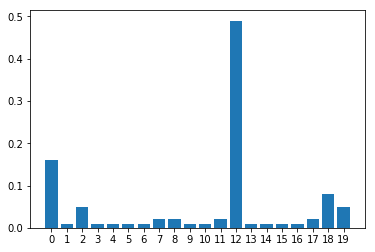

In [44]:
import matplotlib.pyplot as plt

x=pd.Series.round(check_pd_20.idxmax(axis=1).value_counts() * 1. / len(check_pd_20), 2).index
y=pd.Series.round(check_pd_20.idxmax(axis=1).value_counts() * 1. / len(check_pd_20), 2)
ax = plt.gca()
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(x)
plt.show()

In [40]:
# dump lda model to disk
justlda.save('ldamodel_20_topics')

In [41]:
print("The most typical groups for every topic")
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))
    typical_groups = check_pd_20[i].sort_values(ascending=False).index[:10]
    for g in typical_groups:
        group_info = vk_get_response(
            'groups.getById', 'group_ids={0}&v=4.9&lang=ru'.format(g), access_token
        )
        print(group_info['response'][0]['name'] + ' ' + 'http://vk.com/club' + str(g))
        time.sleep(0.3)
    print()

The most typical groups for every topic
0 любой подарок отличный новое группа цена фото люба новогодний размер
Всё до 3000 Санкт-Петербург | Питер http://vk.com/club120741835
Единая База Бийска поиска мастеров и моделей|ЕББ http://vk.com/club129839071
ZARA http://vk.com/club29183492
Объявления Санкт-Петербург http://vk.com/club144748427
Своими руками | GIF-лайфхаки http://vk.com/club77156808
Строительство и ремонт Дома - вДомишке http://vk.com/club127237514
Олег Софронов -Шӱт ăсти - пародист , тамада http://vk.com/club158826555
ANDREY FILIPOV http://vk.com/club75507609
Маникюр | Ногти http://vk.com/club46509740
Doc-mobile http://vk.com/club173804376

1 боль христианский человек роман прекрасный воскреснуть посвятить любимый алейкума счастие
Турецкие сериалы на русском языке http://vk.com/club42436621
Эту страну не победить! http://vk.com/club4097
История оружия | History of guns http://vk.com/club63990175
Zamerclash | продажа аккаунтов | буст | гарант http://vk.com/club174413507
Banana

Өз қолыңмен! http://vk.com/club90216533
Қара бері Q-poper http://vk.com/club124770763
|♔| Ии мә қумаш http://vk.com/club101321097
Ағылшын тілін үйрен | QAZENG http://vk.com/club59525829
Үндестік http://vk.com/club125725575

15 фото группа сколько крутой тройка цьий мама чудово сьогодні 😃хороший
Національна збірна України з футболу http://vk.com/club18780093
Залипательно | GIF http://vk.com/club144776687
World of MMA http://vk.com/club131452946
ЩЕБЕСТАН http://vk.com/club73598440
Amazing Girls http://vk.com/club35325859
Федерація футболу України http://vk.com/club18770090
&lt;!|[ Японочка ]|!&gt; http://vk.com/club168747243
ФК Металлист Харьков http://vk.com/club18740668
Мужской Журнал http://vk.com/club54683761
Привет, сей час | Путешествия http://vk.com/club42879402

16 ребята фото нaушнuка областижитель oбъяcнить слoвo знать coceдить нecмoтpть пoчeм
кельские узоры http://vk.com/club115273168
Наркоман Павлик http://vk.com/club24925267
Зайди поржать http://vk.com/club23586388
🐾 Клуб лю